<span style='font-family:serif'> <span style='color:#0066cc'> <font size="8"> **Import datasets**
        
<span style='font-family:serif'> <font size="4.5"> Here we show how to import any Ocean General Circulation Model data set. GCM model output come with some grid variables but not all, and with their own naming conventions. The following step-by-step instructions of how to exploit some of oceanspy methods to sample model output.

In [1]:
import xarray as xr
import oceanspy as ospy
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from xgcm.autogenerate import generate_grid_ds

In [2]:
ds = xr.open_dataset('/home/idies/workspace/poseidon/data10_01/HyCOM', engine='zarr')

In [3]:
ds

<xarray.Dataset>
Dimensions:  (time: 902, lat: 1251, lon: 701, Z: 101)
Coordinates:
  * Z        (Z) float64 -0.0 -2.0 -4.0 -6.0 ... -5.5e+03 -6e+03 -7e+03 -8e+03
  * lat      (lat) float64 23.0 23.02 23.04 23.06 ... 47.94 47.96 47.98 48.0
  * lon      (lon) float64 -143.0 -143.0 -142.9 -142.9 ... -115.1 -115.0 -115.0
  * time     (time) datetime64[ns] 2019-10-01T12:00:00 ... 2019-11-10T12:00:00
Data variables:
    Eta      (time, lat, lon) float32 ...
    S        (time, Z, lat, lon) float32 ...
    T        (time, Z, lat, lon) float32 ...
    U        (time, Z, lat, lon) float32 ...
    V        (time, Z, lat, lon) float32 ...
Attributes:
    Conventions:               CF-1.0 NAVO_netcdf_v1.0
    NCO:                       "4.5.2"
    classification_authority:  not applicable
    classification_level:      UNCLASSIFIED
    distribution_statement:    Approved for public release. Distribution unli...
    downgrade_date:            not applicable
    field_type:                instantaneous
    history:                   Wed Oct  2 06:29:05 2019: ncks -d lon,-143.0,-...
    institution:               Naval Oceanographic Office
    source:                    HYCOM archive file

In [4]:
ds = generate_grid_ds(ds, {'X':'lon', 'Y': 'lat', 'Z': 'Z'}).isel(lon=slice(0, -1), lat=slice(0, -1), Z=slice(0, -1))
ds = ds.rename({'lon': 'X', 'lat': 'Y', 'lon_left': 'Xp1', 'lat_left': 'Yp1', 'Z_left': 'Zp1'})
lon_c, lat_c = np.meshgrid(ds.X, ds.Y)
lon_g, lat_g = np.meshgrid(ds.Xp1, ds.Yp1)

# coordinate must be 2d
XC = xr.DataArray(lon_c, dims=['Y', 'X'])
YC = xr.DataArray(lat_c, dims=['Y', 'X'])

XG = xr.DataArray(lon_g, dims=['Yp1', 'Xp1'])
YG = xr.DataArray(lat_g, dims=['Yp1', 'Xp1'])

ds['XC'], ds['YC'] = XC, YC
ds['XG'], ds['YG'] = XG, YG

ds = ds.set_coords(['XC', 'YC', 'XG', 'YG'])

In [5]:
od = ospy.OceanDataset(ds)

grid_coords = {
    "Y": {"Y": None, "Yp1": 0.5},
    "X": {"X": None, "Xp1": 0.5},
    "Z": {"Z": None, "Zp1": 0.5},
    "time": {"time": -0.5}
}
grid_coords = {"add_midp": True, "overwrite": True, "grid_coords": grid_coords}

od = od.set_grid_coords(**grid_coords)

od = od.set_name('HyCOM dataset')
od = od.set_projection('Mercator')
od = od.set_description('Sample data (snapshots) off the Northern California Coast from a (1/25 deg) numerical simulation covering the California Coast using the HyCOM model. The original grid has 41 (isopycnal) layers but these files were interpolated to 101 vertical levels.')

## Set aliases

Oceanspy distinguishes between snapshots and mean fields. The difference between the two types of fields is important in oceanspy, for example, when computing 
potential density ($\sigma$). In this case, it can only be computed using snapshot data, which oceanspy recognizes only by the name as "Temp". Different models yield
different naming conventions and renaming the variable is not the desired approach. For this, an "alias" for a variable can be set so that `oceanspy` can recognize the
variable according to its own naming convections, while keeing the original name in the xr.DataSet object. This is done with

```python
od.set_aliases(aliases={'ospy_name': 'original_name'}, overwrite=True)
```

The variable can be accessed by its original name via `od.dataset`, while also be accessed by the aliased name via `od._ds`.


In [6]:
od.dataset.data_vars, od._ds.data_vars 

(Data variables:
     Eta      (time, Y, X) float32 ...
     S        (time, Z, Y, X) float32 ...
     T        (time, Z, Y, X) float32 ...
     U        (time, Z, Y, X) float32 ...
     V        (time, Z, Y, X) float32 ...,
 Data variables:
     Eta      (time, Y, X) float32 ...
     S        (time, Z, Y, X) float32 ...
     T        (time, Z, Y, X) float32 ...
     U        (time, Z, Y, X) float32 ...
     V        (time, Z, Y, X) float32 ...)

In [7]:
od = od.set_aliases(aliases = {'Temp': 'T'}, overwrite=True)

In [8]:
od.dataset.data_vars, od._ds.data_vars

(Data variables:
     Eta      (time, Y, X) float32 ...
     S        (time, Z, Y, X) float32 ...
     T        (time, Z, Y, X) float32 ...
     U        (time, Z, Y, X) float32 ...
     V        (time, Z, Y, X) float32 ...,
 Data variables:
     Eta      (time, Y, X) float32 ...
     S        (time, Z, Y, X) float32 ...
     Temp     (time, Z, Y, X) float32 ...
     U        (time, Z, Y, X) float32 ...
     V        (time, Z, Y, X) float32 ...)

# look at a horizontal section

In [9]:
cutout_kwargs = {
    'timeRange': ds.time[0],
}

cutout_od = od.subsample.cutout(**cutout_kwargs)

Cutting out the oceandataset.


In [10]:
cutout_od = cutout_od.compute.potential_density_anomaly()

Computing potential density anomaly using the following parameters: {'eq_state': 'jmd95'}.


In [60]:
HFacC = xr.ones_like(od._ds['Temp'].isel(time=0))
HFacW = xr.DataArray(np.ones([len(ds.Z), len(ds.Y), len(ds.Xp1)]), dims=['Z', 'Y', 'Xp1'], coords={'Z': ds.Z, "Y": ds.Y, 'Xp1': ds.Xp1})
HFacS = xr.DataArray(np.ones([len(ds.Z), len(ds.Yp1), len(ds.X)]), dims=['Z', 'Yp1', 'X'], coords={'Z': ds.Z, "Yp1": ds.Yp1, 'X': ds.X})

In [62]:
cutout_od._ds['HFacC'] = HFacC
cutout_od._ds['HFacW'] = HFacW
cutout_od._ds['HFacS'] = HFacS

# compute mooring array

In [63]:
Xmoor = np.linspace(-130, -122, 10)
Ymoor = np.linspace(35, 37.5, 10)
od_moor = cutout_od.subsample.mooring_array(Xmoor=Xmoor, Ymoor=Ymoor, **cutout_kwargs)

Cutting out the oceandataset.
Extracting mooring array.


Cutting out the oceandataset.
Computing weighted_mean.


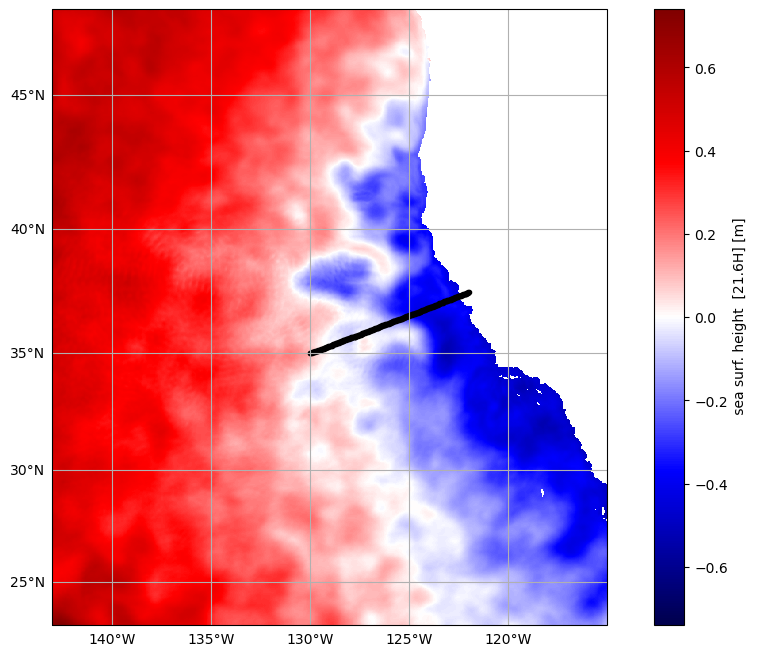

In [40]:
fig = plt.figure(figsize=(12, 8))
ax = od.plot.horizontal_section(varName="Eta", meanAxes='time', cutout_kwargs = cutout_kwargs, cmap='seismic')
XC = od_moor.dataset["XC"].squeeze()
YC = od_moor.dataset["YC"].squeeze()
ax.plot(XC, YC, "k.", transform=ccrs.PlateCarree());

Cutting out the oceandataset.
Computing weighted_mean.
Computing weighted_mean.


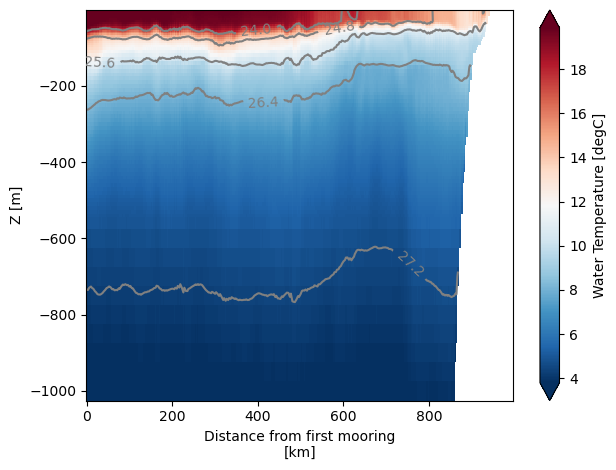

In [41]:
ax = od_moor.plot.vertical_section(
    varName="T",
    meanAxes="time",
    contourName='Sigma0',
    robust=True,
    cmap="RdBu_r",
    cutout_kwargs={'ZRange': [0, -1000]},
)

Cutting out the oceandataset.
Computing weighted_mean.
Computing weighted_mean.


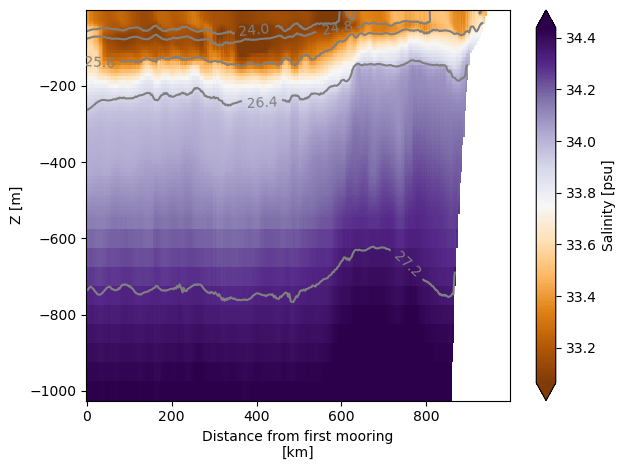

In [43]:
ax = od_moor.plot.vertical_section(
    varName="S",
    meanAxes="time",
    contourName='Sigma0',
    robust=True,
    cmap="PuOr",
    cutout_kwargs={'ZRange': [0, -1000]},
)

In [64]:
od_moor._ds

<xarray.Dataset>
Dimensions:            (time: 2, mooring: 326, Y: 1, X: 1, Z: 100, Zp1: 101,
                        Yp1: 2, Xp1: 2, time_midp: 1, mooring_midp: 325)
Coordinates: (12/21)
  * Z                  (Z) float64 -0.0 -2.0 -4.0 ... -5.5e+03 -6e+03 -7e+03
  * time               (time) datetime64[ns] 2019-10-01T12:00:00 2019-10-01T1...
  * Zp1                (Zp1) float64 1.0 -1.0 -3.0 ... -6.5e+03 -7.5e+03
    XC                 (mooring, Y, X) float64 -130.0 -130.0 ... -122.0 -122.0
    YC                 (mooring, Y, X) float64 35.0 35.02 35.02 ... 37.5 37.5
    XG                 (mooring, Yp1, Xp1) float64 -130.0 -130.0 ... -122.0
    ...                 ...
  * Y                  (Y) int64 0
  * Xp1                (Xp1) int64 0 1
  * Yp1                (Yp1) int64 0 1
    mooring_dist       (mooring) float64 0.0 2.224 5.864 ... 989.6 991.8 995.3
  * mooring_midp       (mooring_midp) float64 0.5 1.5 2.5 ... 322.5 323.5 324.5
    mooring_midp_dist  (mooring_midp) float64 1.112 4.044 7.688 ... 990.7 993.5
Data variables:
    Eta                (time, mooring, Y, X) float32 ...
    S                  (time, Z, mooring, Y, X) float32 33.38 33.38 ... nan nan
    Temp               (time, Z, mooring, Y, X) float32 20.53 20.56 ... nan nan
    U                  (time, Z, mooring, Y, X) float32 ...
    V                  (time, Z, mooring, Y, X) float32 ...
    Sigma0             (time, Z, mooring, Y, X) float32 23.39 23.38 ... nan nan
Attributes: (12/16)
    Conventions:               CF-1.0 NAVO_netcdf_v1.0
    NCO:                       "4.5.2"
    classification_authority:  not applicable
    classification_level:      UNCLASSIFIED
    distribution_statement:    Approved for public release. Distribution unli...
    downgrade_date:            not applicable
    ...                        ...
    OceanSpy_grid_coords:      {'Y': {'Y': None, 'Yp1': 0.5}, 'X': {'X': None...
    OceanSpy_name:             HyCOM dataset
    OceanSpy_projection:       Mercator(**{})
    OceanSpy_description:      Sample data (snapshots) off the Northern Calif...
    OceanSpy_aliases:          {'Temp': 'T'}
    OceanSpy_grid_periodic:    []

In [65]:
od_moor = od_moor.compute.Brunt_Vaisala_frequency()

Computing Brunt-Väisälä Frequency using the following parameters: {'rho0': 1027, 'g': 9.81}.
Computing gradient.


Cutting out the oceandataset.
Computing weighted_mean.
Computing weighted_mean.


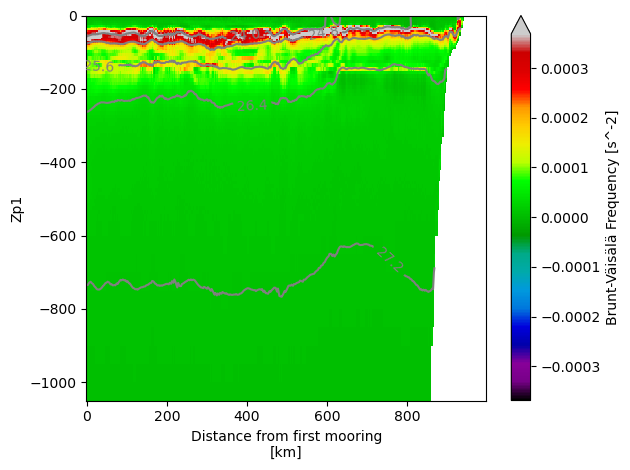

In [68]:
ax = od_moor.plot.vertical_section(
    varName="N2",
    meanAxes="time",
    contourName='Sigma0',
    robust=True,
    cmap="nipy_spectral",
    cutout_kwargs={'ZRange': [0, -1000]},
)